In [191]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import scipy.optimize as sop
import warnings
warnings.filterwarnings('ignore')

In [3]:
mosprime3m = pd.read_csv('mosprime3m.csv',header=None,
                         index_col=0, names=['r3m'])['r3m']
mosprime3m_between = pd.read_csv('mosprime3m_between.csv', header=None,
                                 index_col=0, names=['r3m'])['r3m']
mosprime3m_short = pd.read_csv('mosprime3m_short.csv', header=None,
                               index_col=0, names=['r3m'])['r3m']

### Калибровка моделей

##### ML

###### Модель Мертона

\begin{equation}
dr_t = \alpha dt + \sigma dW_t
\end{equation}

In [233]:
data = mosprime3m_short

In [223]:
data = mosprime3m_between

Повторим рассуждения из предыдущего раздела. 

Введем функцию, генерирующую траектории случайного процесса:

\begin{align*}
r_{t}-r_{t-1} = \alpha dt + \sigma \sqrt{dt} N(0,1),
\end{align*}

где $dt = \frac{1}{252}$. 

Которая будет строиться рекуррентно:

\begin{align*}
& r_{0} = r0\\
& r_{t} = r_{t-1} + \alpha dt + \sigma \sqrt{dt} N(0,1)   \quad [1]
\end{align*}

А случайная составляющая генерируется каждый раз независимо от остальных.

In [5]:
def merton_path(r0, days, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    a = a # альфа 
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = r[t - 1] +  a*dt + vol * rand[t] * np.sqrt(dt)
    merton = pd.DataFrame(r[:, 0], columns=['index'])
    merton = merton.values.flatten()
    return merton

In [6]:
def m_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated Merton Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(merton_path(data[0], len(data), opt[0], opt[1]),
                 lw=0.8, alpha=0.7)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()

В данном случае процентная ставка в момент $t$ имеет нормальное распределение со следующими параметрами:
    
\begin{align*}
& E(r_t) = \alpha t \\
& Var(r_t) = \sigma^2 t
\end{align*}

In [234]:
p0 = np.array([ 0.45,  0.2 ])

Введем функцию плотности нормального распределения с матожиданием $\mu$ и стандартным отклонением $\sigma$:

\begin{align*}
f(x, \mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma ^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{align*}

In [196]:
def dN(x, mu, sigma):
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
    return pdf

В таком случае можно задать функцию правдоподобия, как произведение функци плотностей нормального распределения с соответствующими матожиданиями и дисперсиями:

\begin{align*}
& L = \prod_{i=1}^{t} f(x, \mu_i, \sigma_i)  \\
& \mu_i = r_0 + \alpha i \\
& \sigma_i = \sigma \sqrt{t}
\end{align*}


In [197]:
def merton_ml(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    L = -np.prod(dN(x, mu, sigma))
    return L

In [238]:
 def merton_ml(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt(t)
    mu = min(data) + a * t
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [254]:
def merton_ml_diff(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    dx = np.diff(data.values)
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = 1/252
    sigma = vol * np.sqrt(dt)
    mu =  a * dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

\begin{align*}
& \mu_t = r_{t-1} + \alpha t \\
& \sigma_t = \sigma \sqrt{t} \\
& t = \frac{1}{252}
\end{align*}

In [255]:
 def merton_ml(p0):
    a, vol = p0
    if vol < 0.0:
        return np.inf
    x = data[1:].values
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = 1/252
    sigma = vol * np.sqrt(dt)
    mu = data[:-1].values + a * dt
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [256]:
opt_ML = sop.fmin(merton_ml, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)

Optimization terminated successfully.
         Current function value: 95.001512
         Iterations: 55
         Function evaluations: 107


In [257]:
opt_ML

array([ 1.01766808,  5.45545827])

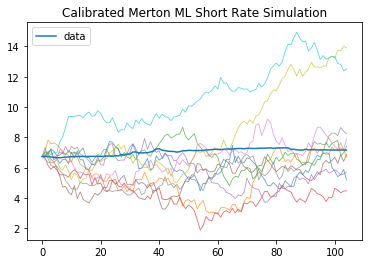

In [258]:
m_p(data, opt_ML, num_paths=10, title='Calibrated Merton ML Short Rate Simulation')

### Однофакторная модель Hull-White

\begin{align*}
& dr_t = (\theta(t) - a r_t) dt + \sigma dW_t \\
& \theta(t) := \lambda + \beta t
\end{align*}

Траектории случайного процесса:

\begin{align*}
r_{t}-r_{t-1} = (\lambda + \beta t - a r_t) dt + \sigma \sqrt{dt} N(0,1),
\end{align*}


где $dt = \frac{1}{252}$. 

Которая будет строиться рекуррентно:

\begin{align*}
& r_{0} = r0\\
& r_{t} = \frac{r_{t-1} + (\lambda + \beta t) dt + \sigma \sqrt{dt} N(0,1)}{1 + \alpha dt}   
\end{align*}

А случайная составляющая генерируется каждый раз независимо от остальных.

In [17]:
def HW1_path(r0, days, l, b, a, vol):
    # параметры модели
    r0 = r0 # начальная ставка
    T = days # число лет
    l = l # лямбда
    a = a # альфа 
    b = b # бета
    vol = vol # волатильность
    # симуляция
    I = 1 
    dt = 1 / 252.
    # путь
    rand = np.random.standard_normal((T, I)) # генерация случайных величин
    r = np.zeros_like(rand) # матрица ставок
    r[0] = r0 # начальное значение
    for t in range(1, T): 
        r[t] = (r[t - 1] +  (l + b * t) * dt + vol * rand[t] * np.sqrt(dt))/ (1 + a * dt)
    HW1 = pd.DataFrame(r[:, 0], columns=['index'])
    HW1 = HW1.values.flatten()
    return HW1

В данном случае процентная ставка в момент $t$ имеет нормальное распределение со следующими матожиданием и дисперсией:
    
\begin{equation}
E(r_t) = r_0 e^{-\alpha t} + \frac{e^{-\alpha t}(\lambda + \beta t)(1 + e^{\alpha t}(-1 + \alpha t))}{\alpha^2}\\
\end{equation}

\begin{equation}
Var(r_t) = \frac{\sigma^2 }{2 \alpha} (1 - e^{-2\alpha t})
\end{equation}

In [123]:
p0 = np.array([  1.13736131e-02,   1.34817886e-04,   2.38530484e-01, 2.20405094e-01])

Аналогично задаем функцию правдоподобия, как произведение функций плотностей нормального распределения с соответствующими матожиданиями и дисперсиями:

\begin{align*}
& L = \prod_{i=1}^{t} f(x, \mu_i, \sigma_i)  \\
& \mu_i = r_0 e^{-\alpha i} + \frac{e^{-\alpha i}(\lambda + \beta i)(1 + e^{\alpha i}(-1 + \alpha i))}{\alpha^2} \\
& \sigma_i = \sigma \sqrt{\frac{(1 - e^{-2\alpha i})}{2 \alpha}}
\end{align*}

Где $i = \frac{номер \ дня}{252}$.

In [21]:
def HW1_ml(p0):
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0:
        return 10000.0
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = min(data) * np.exp(-a * t) + np.exp(-a * t)*(l + b * t)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    L = -np.prod(dN(x, mu, sigma))
    return L

In [26]:
opt_HW1_ml = sop.fmin(HW1_ml, p0,
               maxiter=100, maxfun=100, xtol=0.0001, ftol=0.0001)

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 9
         Function evaluations: 53


In [27]:
opt_HW1_ml

array([  1.23292111e-02,   1.07149882e-04,   2.81015602e-01,
         2.65320072e-01])

Снова введем вспомогательную функцию для отрисовки траекторий.

In [24]:
def HW1_p(data, opt, num_paths=10, alpha=0.7, title='Calibrated HW1 Short Rate Simulation'):
    for i in range(num_paths):
        plt.plot(HW1_path(data[0], len(data), opt[0], opt[1],
                      opt[2], opt[3]), lw=0.8, alpha=alpha)
    plt.title(title)
    plt.plot(data.values.flatten(), label = 'data')
    plt.legend()
    plt.tight_layout
    plt.show()

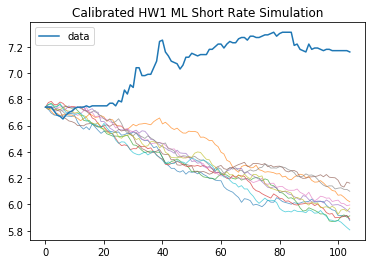

In [28]:
HW1_p(data, opt_HW1_ml, num_paths=10, alpha=0.7, title='Calibrated HW1 ML Short Rate Simulation')

##### Сравнение реализаций максимального правдоподобия

In [29]:
import time

В этот раз возьмем полные данные, чтобы проверить способность хранить в памяти большие объемы информации.

In [96]:
data = mosprime3m

Второй моделью будет логарифмическая функция правдоподобия. Она должна давать те же оптимальные значения. 

\begin{align*}
& L = \prod_{i=1}^{t} f(x, \mu_i, \sigma_i)  \\
& l = \ln L = \sum_{i=1}^{t} \ln f(x, \mu_i, \sigma_i) \\ 
& \mu_i = r_0 e^{-\alpha i} + \frac{e^{-\alpha i}(\lambda + \beta i)(1 + e^{\alpha i}(-1 + \alpha i))}{\alpha^2} \\
& \sigma_i = \sigma \sqrt{\frac{(1 - e^{-2\alpha i})}{2 \alpha}}
\end{align*}

Где $i = \frac{номер \ дня}{252}$.


Особенностью реализации является то, что сначала высчитываются плотности нормального распределения, затем от них берется логарифм, а уже после этого они складываются.

In [97]:
def HW1_ml_v2(p0):
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = min(data) * np.exp(-a * t) + np.exp(-a * t)*(l + b * t)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    L = -np.sum(np.log(dN(x, mu, sigma)))
    return L

Третий способ идейно такой же - сумма логарифмов функций плотностей, но технически это реализовано иначе.

\begin{align*}
& l = \ln L = \sum_{i=1}^{t} \ln f(x, \mu_i, \sigma_i) \\ 
& l = -\frac{t}{2} \ln{2 \pi} - \sum_{i=1}^{t} \ln \sigma_i - \sum_{i=1}^{t} \frac{(x-\mu_i)^2}{2\sigma_i^2}\\
& \mu_i = r_0 e^{-\alpha i} + \frac{e^{-\alpha i}(\lambda + \beta i)(1 + e^{\alpha i}(-1 + \alpha i))}{\alpha^2} \\
& \sigma_i = \sigma \sqrt{\frac{(1 - e^{-2\alpha i})}{2 \alpha}}
\end{align*}

В данном случае в явном виде выписана формула логарифмического правдоподобия для нормального распределения, каждое слагаемое которой считается отдельно.

In [142]:
def HW1_ml_v3(p0):
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0 or b < 0.0 or l < 0.0:
        return np.inf
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = min(data) * np.exp(-a * t) + np.exp(-a * t)*(l + b * t)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [143]:
HW1_ml_v2(p0)

inf

In [144]:
HW1_ml_v3(p0)

1529822.2302222138

In [145]:
HW1_ml(p0)

-0.0

Как видно выше для больших данных второй и третий метод не дают одинаковый результат, хотя должны.

In [146]:
time_start = time.time()
opt_HW1_ml_v1 = sop.fmin(HW1_ml, p0,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)
time_end = time.time()
delta_v1 = time_end - time_start
opt_HW1_ml_v1

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 8
         Function evaluations: 47


array([  1.13736131e-02,   1.34817886e-04,   2.38530484e-01,
         2.20405094e-01])

In [147]:
time_start = time.time()
opt_HW1_ml_v2 = sop.fmin(HW1_ml_v2, p0,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)
time_end = time.time()
delta_v2 = time_end - time_start
opt_HW1_ml_v2 

array([  1.13736131e-02,   1.34817886e-04,   2.38530484e-01,
         2.20405094e-01])

In [148]:
time_start = time.time()
opt_HW1_ml_v3 = sop.fmin(HW1_ml_v3, p0,
               maxiter=10000, maxfun=10000, xtol=0.0001, ftol=0.0001)
time_end = time.time()
delta_v3 = time_end - time_start
opt_HW1_ml_v3

Optimization terminated successfully.
         Current function value: 39470.762195
         Iterations: 378
         Function evaluations: 780


array([  1.90320517e-04,   1.05656470e-08,   6.07393994e-11,
         7.21213098e-01])

In [149]:
print(delta_v1, delta_v2, delta_v3)

0.025567293167114258 0.856778621673584 0.3363940715789795


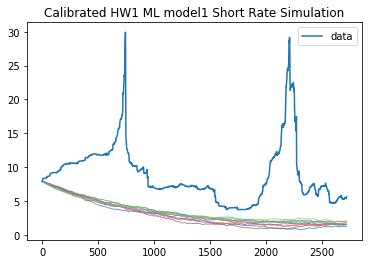

In [150]:
HW1_p(data, opt_HW1_ml_v1, num_paths=10, alpha=0.7,
      title='Calibrated HW1 ML model1 Short Rate Simulation')

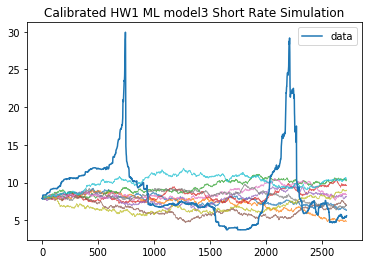

In [151]:
HW1_p(data, opt_HW1_ml_v3, num_paths=10, alpha=0.7,
      title='Calibrated HW1 ML model3 Short Rate Simulation')

На полных данных относительно корректно работает только третий метод.

In [152]:
data = mosprime3m_between.dropna()

In [153]:
time_start = time.time()
opt_HW1_ml_v1 = sop.fmin(HW1_ml, p0,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)
time_end = time.time()
delta_v1 = time_end - time_start
opt_HW1_ml_v1

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 8
         Function evaluations: 47


array([  1.13736131e-02,   1.34817886e-04,   2.38530484e-01,
         2.20405094e-01])

In [154]:
time_start = time.time()
opt_HW1_ml_v2 = sop.fmin(HW1_ml_v2, p0,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)
time_end = time.time()
delta_v2 = time_end - time_start
opt_HW1_ml_v2 

array([  1.13736131e-02,   1.34817886e-04,   2.38530484e-01,
         2.20405094e-01])

In [155]:
time_start = time.time()
opt_HW1_ml_v3 = sop.fmin(HW1_ml_v3, p0,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)
time_end = time.time()
delta_v3 = time_end - time_start
opt_HW1_ml_v3

Optimization terminated successfully.
         Current function value: 2954.390907
         Iterations: 503
         Function evaluations: 928


array([  9.51088329e-11,   2.41985722e-09,   6.04601034e-03,
         7.13234153e-01])

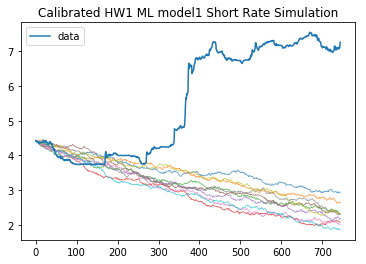

In [156]:
HW1_p(data, opt_HW1_ml_v1, num_paths=10, alpha=0.7,
      title='Calibrated HW1 ML model1 Short Rate Simulation')

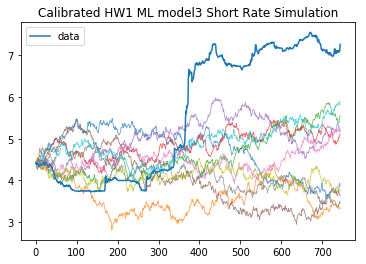

In [157]:
HW1_p(data, opt_HW1_ml_v3, num_paths=10, alpha=0.7,
      title='Calibrated HW1 ML model3 Short Rate Simulation')

In [158]:
print(delta_v1, delta_v2, delta_v3)

0.01002645492553711 0.3053121566772461 0.24816060066223145


Да. Очевидно нормально работает только третий способ.

In [268]:
def HW1_ml_final(p0, penalty=np.inf):
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0 or b < 0.0 or l < 0.0:
        return penalty 
    x = data.values
    t = (np.array(list(range(len(data)))) + 1)/252
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = min(data) * np.exp(-a * t) + np.exp(-a * t)*(l + b * t)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [276]:
def HW1_ml_final_len1(p0, penalty=np.inf):
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0 or b < 0.0 or l < 0.0:
        return penalty 
    x = data[1:].values
    t = np.array([1/252]*len(x))
    sigma = vol * np.sqrt((1-np.exp(-2 * a * t))/(2 * a))
    mu = data[:-1] * np.exp(-a * t) + np.exp(-a * t)*(l + b * t)*(1 + np.exp(a * t)*(-1 + a * t))/(a**2)
    const = -1/2 * len(x) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((x-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

In [ ]:
dx = np.diff(data.values)
    t = (np.array(list(range(len(data)))) + 1)/252
    dt = np.array([1/252]*len(x))

In [316]:
def HW1_ml_final_diff(p0, penalty=np.inf):
    l, b, a, vol = p0
    if a < 0.0 or vol < 0.0 or b < 0.0 or l < 0.0:
        return penalty 
    x = data.values
    dx = np.diff(data.values)
    dt = np.array([1/252]*len(dx))
    sigma1 = vol * np.sqrt((1-np.exp(-2 * a * dt))/(2 * a))
    sigma = np.sqrt (vol ** 2 * dt + (sigma1 * a * dt) ** 2) 
    mu1 = data[:-1] * np.exp(-a * dt) + np.exp(-a * dt)*(l + b * dt)*(1 + np.exp(a * dt)*(-1 + a * dt))/(a**2)
    mu = ((l + b * dt) - a * mu1)dt
    const = -1/2 * len(dx) * np.log(2 * np.pi)
    sum1 = - np.sum(np.log(sigma))
    sum2 = - np.sum(((dx-mu)/(np.sqrt(2) * sigma))**2)
    L = - (const + sum1 + sum2)
    return L

SyntaxError: invalid syntax (<ipython-input-316-9c7c3a35e274>, line 11)

На коротких данных проверим влияние начального приближения:

In [269]:
data = mosprime3m_short

In [270]:
p1 = np.array([0.01, 0.01, 0.01, 0.01])
p2 = np.array([0.1, 0.1, 0.1, 0.1])
p3 = np.array([0.6, 0.6, 0.6, 0.6])

Optimization terminated successfully.
         Current function value: 10240.672946
         Iterations: 337
         Function evaluations: 673
[  1.87518655e-05   4.23939504e-04   1.77135616e-10   5.49139657e-02]


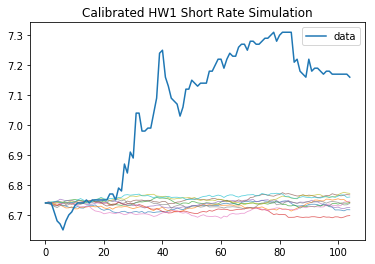

In [271]:
HW1_ml_ex1 = sop.fmin(HW1_ml_final, p1,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex1)
HW1_p(data, HW1_ml_ex1, num_paths=10)

Optimization terminated successfully.
         Current function value: 192.705671
         Iterations: 371
         Function evaluations: 741
[  1.67387090e-03   3.17664366e-06   1.16051195e-09   3.27225319e-01]


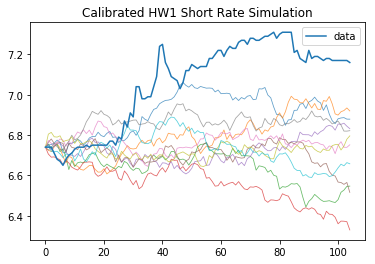

In [272]:
HW1_ml_ex2 = sop.fmin(HW1_ml_final, p2,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex2)
HW1_p(data, HW1_ml_ex2, num_paths=10)

Optimization terminated successfully.
         Current function value: -27.613693
         Iterations: 398
         Function evaluations: 810
[  1.14372606e+01   6.32139917e-01   1.78457570e-07   4.95877101e-01]


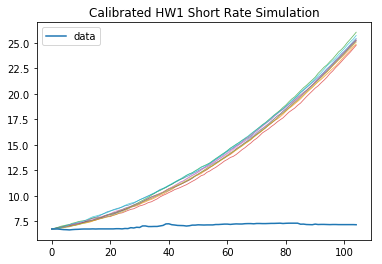

In [273]:
HW1_ml_ex3 = sop.fmin(HW1_ml_final, p3,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex3)
HW1_p(data, HW1_ml_ex3, num_paths=10)

In [274]:
p4 = np.array([  1.13736131e-02,   1.34817886e-04,   2.38530484e-01, 2.20405094e-01])

Optimization terminated successfully.
         Current function value: 24.840012
         Iterations: 365
         Function evaluations: 730
[  3.94986670e-05   1.19358039e-05   1.67362388e-10   7.10574104e-01]


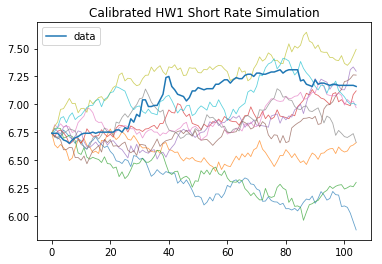

In [275]:
HW1_ml_ex4 = sop.fmin(HW1_ml_final, p4,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex4)
HW1_p(data, HW1_ml_ex4, num_paths=10)

Optimization terminated successfully.
         Current function value: -203.378459
         Iterations: 183
         Function evaluations: 326
[ 0.08483474  0.03091841  0.07288349  0.54058535]


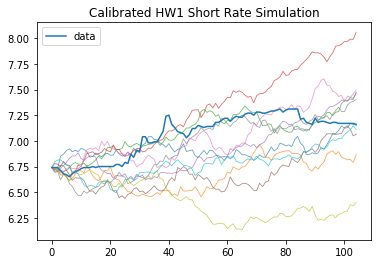

In [317]:
HW1_ml_ex1 = sop.fmin(HW1_ml_final_diff, p1,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex1)
HW1_p(data, HW1_ml_ex1, num_paths=10)

Optimization terminated successfully.
         Current function value: -204.031954
         Iterations: 205
         Function evaluations: 368
[  1.99904220e-02   5.33196433e-08   2.32037980e-02   5.39219461e-01]


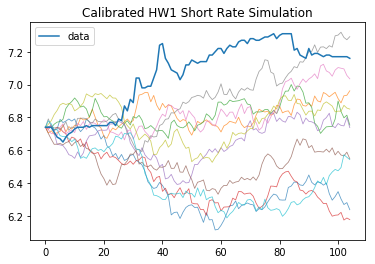

In [318]:
HW1_ml_ex2 = sop.fmin(HW1_ml_final_diff, p2,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex2)
HW1_p(data, HW1_ml_ex2, num_paths=10)

Optimization terminated successfully.
         Current function value: -204.297870
         Iterations: 126
         Function evaluations: 250
[  8.50288350e-01   9.27777695e-01   1.90401097e-06   5.37891507e-01]


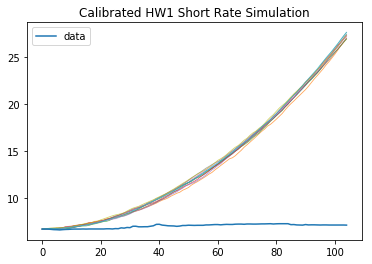

In [319]:
HW1_ml_ex3 = sop.fmin(HW1_ml_final_diff, p3,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex3)
HW1_p(data, HW1_ml_ex3, num_paths=10)

Optimization terminated successfully.
         Current function value: -204.289920
         Iterations: 126
         Function evaluations: 273
[  1.52284154e-02   6.82949655e-06   2.38522837e-07   5.39042694e-01]


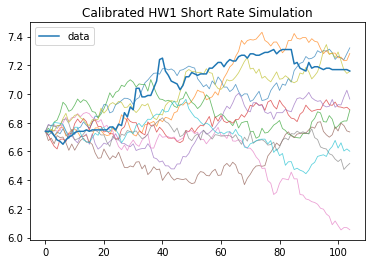

In [324]:
HW1_ml_ex4 = sop.fmin(HW1_ml_final_diff, p4,
               maxiter=1000, maxfun=1000, xtol=0.0001, ftol=0.0001)

print(HW1_ml_ex4)
HW1_p(data, HW1_ml_ex4, num_paths=10, alpha = 0.7)